In [1]:
import numpy as np
import pandas as pd


In [2]:
df = pd.read_csv('/Users/mannes/thesis/complex_task_gen/output/output/df_eval_daniil.csv')

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

# Assuming df_eval is your DataFrame
alphas = np.linspace(-1, 2, 301)
best_alpha, best_corr = None, -1

for alpha in alphas:
    df["score"] = df["logp_sum"] / (df["n_tokens"] ** alpha)
    rho, _ = spearmanr(df["score"], df["pass1_int"])  # assuming pass1_int is 1/0 pass label
    if abs(rho) > best_corr:
        best_alpha, best_corr = alpha, abs(rho)

print(f"Best alpha: {best_alpha:.3f}, correlation: {best_corr:.3f}")

Best alpha: -0.610, correlation: 0.321


In [4]:
df["score_alpha"] = df["logp_sum"] / (df["n_tokens"] ** -0.610)

from scipy.stats import pearsonr, spearmanr

spearman_corr = spearmanr(df["score_alpha"], df["pass1_int"])
pearson_corr = pearsonr(df["score_alpha"], df["pass1_int"])

print("Spearman:", spearman_corr.correlation, "p-value:", spearman_corr.pvalue)
print("Pearson:", pearson_corr.correlation, "p-value:", pearson_corr.pvalue)


Spearman: 0.320909579674028 p-value: 5.650889589657209e-33
Pearson: 0.3076907077016625 p-value: 2.553171736017514e-30


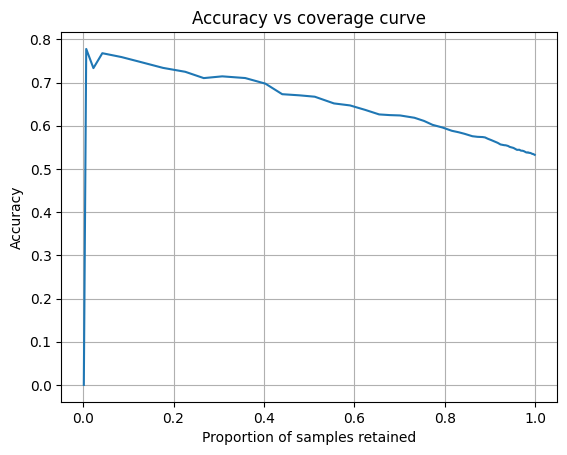

In [5]:
import matplotlib.pyplot as plt

thresholds = np.linspace(df["score_alpha"].min(), df["score_alpha"].max(), 100)
pass_rates = [(df["score_alpha"] > t).mean() for t in thresholds]
accuracies = [df[df["score_alpha"] > t]["pass1_int"].mean() for t in thresholds]

plt.plot(pass_rates, accuracies)
plt.xlabel("Proportion of samples retained")
plt.ylabel("Accuracy")
plt.title("Accuracy vs coverage curve")
plt.grid()
plt.show()


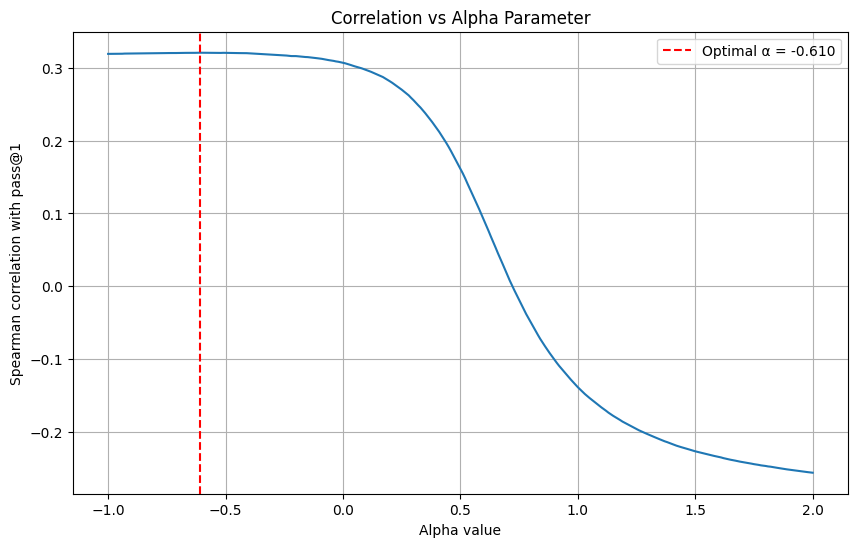

Summary statistics:
       Group  Count         Mean          Std           Min         Max
0    Correct    702 -2825.822782  1482.730299 -11285.764555 -845.102957
1  Incorrect    617 -4019.755222  2182.835832 -16254.009805 -633.406436

T-test results: t-statistic = 11.4599, p-value = 0.00000000
The mean scores are statistically significantly different.


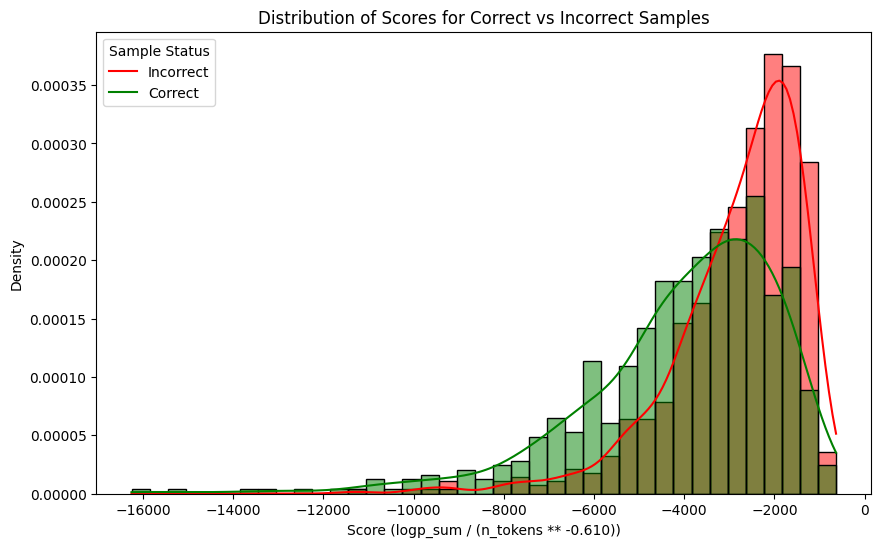

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr, ttest_ind

# Plot correlation vs alpha
alphas = np.linspace(-1, 2, 301)
correlations = []

for alpha in alphas:
    df["score"] = df["logp_sum"] / (df["n_tokens"] ** alpha)
    rho, _ = spearmanr(df["score"], df["pass1_int"])
    correlations.append(rho)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(alphas, correlations)
plt.axvline(x=-0.610, color='r', linestyle='--', label=f'Optimal α = -0.610')
plt.xlabel('Alpha value')
plt.ylabel('Spearman correlation with pass@1')
plt.title('Correlation vs Alpha Parameter')
plt.grid(True)
plt.legend()
plt.show()

# Calculate scores with optimal alpha
df["score_optimal"] = df["logp_sum"] / (df["n_tokens"] ** -0.610)

# Group by correct/incorrect
correct_scores = df[df["pass1_int"] == 1]["score_optimal"]
incorrect_scores = df[df["pass1_int"] == 0]["score_optimal"]

# Statistical summary
summary = pd.DataFrame({
    'Group': ['Correct', 'Incorrect'],
    'Count': [len(correct_scores), len(incorrect_scores)],
    'Mean': [correct_scores.mean(), incorrect_scores.mean()],
    'Std': [correct_scores.std(), incorrect_scores.std()],
    'Min': [correct_scores.min(), incorrect_scores.min()],
    'Max': [correct_scores.max(), incorrect_scores.max()]
})

print("Summary statistics:")
print(summary)

# Run t-test
t_stat, p_value = ttest_ind(correct_scores, incorrect_scores, equal_var=False)
print(f"\nT-test results: t-statistic = {t_stat:.4f}, p-value = {p_value:.8f}")
if p_value < 0.05:
    print("The mean scores are statistically significantly different.")

# Visualize the distributions
# Visualize the distributions
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="score_optimal", hue="pass1_int",
             kde=True, common_norm=False, stat="density",
             palette=["green", "red"])
# Update legend labels after plotting
plt.legend(title='Sample Status', labels=["Incorrect", "Correct"])
plt.title('Distribution of Scores for Correct vs Incorrect Samples')
plt.xlabel('Score (logp_sum / (n_tokens ** -0.610))')
plt.ylabel('Density')
plt.show()

In [11]:

df_corr = pd.read_csv('/Users/mannes/thesis/complex_task_gen/output/output/df_corr.csv')

In [10]:
# Few ideas:
# Try log of tokens
# If we want for sanity check, try to run 7b model if possible -> Run entire pipeline with larger model

# Try to run with 7b model -> This is the correlation between metric x and y
# Then forget about this
# Use Pass@1 as novelty -> Take target model, when I generate, I will use the pass@1 as novelty
# Run model 4 times on -> calculate probability of the model being correct -> Then average this as the target model and give it as a reward -> more wasteful  but will still be good
# For 1.5B it will be quick enoguh
# Run target model on VLLM --> Generate 8 solutions for given task , average the  'likelihood' of the model being correct
# Style of the solution can be



In [12]:
df_corr

,Unnamed: 0,metric,pearson,pearson_p,spearman,spearman_p
0,0,logp_sum,0.303610,1.583736e-29,0.307090,3.345831e-30
1,1,avg_logp,-0.123418,6.949343e-06,-0.138852,4.136044e-07
2,2,perplexity,0.073934,7.225654e-03,0.138852,4.136044e-07
3,3,token_entropy,-0.010701,6.978139e-01,-0.006712,8.075846e-01
4,4,prompt_len,-0.211615,8.082803e-15,-0.191873,2.106645e-12
5,5,num_ops,-0.054371,4.835287e-02,-0.044978,1.025105e-01
6,6,voting_entropy,-0.036534,1.848315e-01,-0.036534,1.848315e-01


In [13]:
df

,Unnamed: 0,id,question,answer_x,solution,difficulty,pass1,numeric_answer,generated_answer,generated_numeric_answer,...,n_tokens,prompt,answer_y,tokens,generated_numeric_answer_v2,pass1_2,pass1_int,score,score_alpha,score_optimal
0,0,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,unk,1,18,Janet's ducks lay 16 eggs per day.\nShe eats 3...,NaN,...,60,You are a math reasoning assistant.\n\n**Quest...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,"[{'position': 0, 'token': 'Jan', 'token_id': 1...",18.0,False,1,-0.037396,-1636.055443,-1636.055443
1,1,1,A robe takes 2 bolts of blue fiber and half th...,It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...,3,unk,0,3,The problem states that a robe takes 2 bolts o...,NaN,...,47,You are a math reasoning assistant.\n\n**Quest...,It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...,"[{'position': 0, 'token': 'It', 'token_id': 21...",3.0,False,0,-0.059065,-1366.167873,-1366.167873
2,2,2,Josh decides to try flipping a house. He buys...,The cost of the house and repairs came out to ...,70000,unk,0,70000,"To determine the profit Josh made, we need to ...",NaN,...,210,You are a math reasoning assistant.\n\n**Quest...,The cost of the house and repairs came out to ...,"[{'position': 0, 'token': 'The', 'token_id': 7...",200000.0,False,0,-0.004262,-4904.752904,-4904.752904
3,3,3,James decides to run 3 sprints 3 times a week....,He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...,540,unk,0,540,To determine the total number of meters James ...,NaN,...,47,You are a math reasoning assistant.\n\n**Quest...,He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...,"[{'position': 0, 'token': 'He', 'token_id': 15...",180.0,False,0,-0.057911,-1339.469558,-1339.469558
4,4,4,"Every day, Wendi feeds each of her chickens th...","If each chicken eats 3 cups of feed per day, t...",20,unk,0,20,To determine how many cups of feed Wendi needs...,NaN,...,108,You are a math reasoning assistant.\n\n**Quest...,"If each chicken eats 3 cups of feed per day, t...","[{'position': 0, 'token': 'If', 'token_id': 26...",0.0,False,0,-0.012382,-2512.110874,-2512.110874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,1314,1314,John had a son James when he was 19. James is...,Dora is 12-3=<<12-3=9>>9\nSo James is 9*2=<<9*...,8,unk,0,8,To determine the age of John's youngest son in...,NaN,...,114,You are a math reasoning assistant.\n\n**Quest...,Dora is 12-3=<<12-3=9>>9\nSo James is 9*2=<<9*...,"[{'position': 0, 'token': 'D', 'token_id': 35,...",21.0,False,0,-0.011824,-2762.412909,-2762.412909
1315,1315,1315,There are some oranges in a basket. Ana spends...,There are 60 minutes in an hour. Ana peels an ...,5,unk,1,5,"In an hour, Ana can peel 60 / 3 = 20 oranges.\...",5.0,...,107,You are a math reasoning assistant.\n\n**Quest...,There are 60 minutes in an hour. Ana peels an ...,"[{'position': 0, 'token': 'There', 'token_id':...",5.0,True,1,-0.011517,-2280.518059,-2280.518059
1316,1316,1316,Mark's car breaks down and he needs to get a n...,The discount on the radiator was 400*.8=$<<400...,230,unk,1,230,To find out how much Mark paid for the new rad...,NaN,...,112,You are a math reasoning assistant.\n\n**Quest...,The discount on the radiator was 400*.8=$<<400...,"[{'position': 0, 'token': 'The', 'token_id': 7...",470.0,False,1,-0.012738,-2841.599230,-2841.599230
1317,1317,1317,"Farmer Brown has 20 animals on his farm, all e...",Let C be the number of chickens.\nThere are 20...,5,unk,1,5,"Let x be the number of chickens.\nThen, the nu...",5.0,...,85,You are a math reasoning assistant.\n\n**Quest...,Let C be the number of chickens.\nThere are 20...,"[{'position': 0, 'token': 'Let', 'token_id': 1...",5.0,True,1,-0.019410,-2107.744137,-2107.744137


0       [{'position': 0, 'token': 'Jan', 'token_id': 1...
1       [{'position': 0, 'token': 'It', 'token_id': 21...
2       [{'position': 0, 'token': 'The', 'token_id': 7...
3       [{'position': 0, 'token': 'He', 'token_id': 15...
4       [{'position': 0, 'token': 'If', 'token_id': 26...
                              ...                        
1314    [{'position': 0, 'token': 'D', 'token_id': 35,...
1315    [{'position': 0, 'token': 'There', 'token_id':...
1316    [{'position': 0, 'token': 'The', 'token_id': 7...
1317    [{'position': 0, 'token': 'Let', 'token_id': 1...
1318    [{'position': 0, 'token': 'There', 'token_id':...
Name: tokens, Length: 1319, dtype: object

In [ ]:
# Run for 7B Model --> check that daniil is not insane
# Update novelty score